# Import Libraries

In [1]:
# For drive access
from google.colab import drive
drive.mount('/content/drive')

# Standard libraries
import numpy as np
import pandas as pd
import time

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


# Self Defined Class Methods For Feature Extraction

In [2]:
class Framed:

  def __init__(self,
               dataframe,
               sr=16000,
               window_size_s=5.0,
               hop_size_s=2.5,
               do_augment=False
               ):
    """
    Instantiate the Framed class, create train and val dfs.

    The extract_framed() method is automatically called when the class is
    instantiated to extract the framed audios and add to the train and val dfs.

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information.
      sr (int): Sample rate of the audio files.
      window_size_s (float): Window size in seconds for framing the audio.
      hop_size_s (float): Hop size in seconds for framing the audio.
      augment (bool): Whether to apply augmentation to the audio.
    """
    # instantiate class
    self.sr = sr
    self.frame_length = int(window_size_s * sr)
    self.frame_step = int(hop_size_s * sr)

    # split the dataframe to train and val by calling the _split_train_val() method
    self.train_df, self.val_df = self._split_train_val(dataframe)

    # add framed audios to train and val dfs by calling the extract_framed() method
    # only training data could be augmented, validation is never augmented
    self.extract_framed(self.train_df, augment=do_augment)
    self.extract_framed(self.val_df, augment=False)


  ########################################
  # _split_train_val function is called when the class is instantiated
  ########################################
  def _split_train_val(self,
                       dataframe):
    """
    Split the dataframe to train and val based on predefined 'set' column.

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information.

    Returns:
      tuple: Tuple of train and val dataframes containing audio file information.
    """
    # extract the train set from dataframe & shuffle the train set
    train_df = dataframe[dataframe['set'] == 'train']
    train_df = train_df.sample(frac=1, random_state=1234)

    # extract the val set from dataframe & shuffle the val set
    val_df = dataframe[dataframe['set'] == 'val']
    val_df = val_df.sample(frac=1, random_state=1234)

    return train_df, val_df


  ########################################
  # augment function is called by extract_framed function if do_augment=True
  ########################################
  def augment(self, audio_array):
    """
    Apply random augmentation if needed.

    Parameters:
      audio_array (npy): Training audio array.

    Returns:
      audio_array (npy): Augmented audio array.
    """
    choice = np.random.choice(['original','noise','shift','pitch'])

    # if the audio is short (less than 7 seconds in duration), stretch it first
    if len(audio_array) <= 7*self.sr:
      audio_array = librosa.effects.time_stretch(y=audio_array, rate=np.random.uniform(low=0, high=1))
    # if the audio is not short, apply a random augmentation at random magnitude
    elif choice == 'noise':
      noise_amp = np.random.normal(loc=0.0, scale=0.05)*np.amax(audio_array)
      audio_array = audio_array + noise_amp*np.random.normal(size=audio_array.shape[0])
    elif choice == 'shift':
      shift_range = int(np.random.uniform(low=-5, high=5)*1000)
      audio_array = np.roll(audio_array, shift_range)
    elif choice == 'pitch':
      audio_array = librosa.effects.pitch_shift(y=audio_array, sr=self.sr, n_steps=np.random.uniform(low=0, high=1))
    else:
      audio_array = audio_array

    return audio_array


  ########################################
  # extract_framed function is called when the class is instantiated to extract the framed audios
  ########################################
  def extract_framed(self, dataframe, augment):
    """
    Load audio files from the given DataFrame, extract framed audios,
    and add the framed audios to the given DataFrame

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information.
      augment (bool): Whether to apply augmentation to the audio.
    """
    # load audios
    audios = []
    for filename in dataframe['filename_npy']:
      audio = np.load('/content/drive/MyDrive/project/train_npy/' + filename)
      # if augment is true, call the augment function to apply augmentation to the audio
      if augment:
        audio = self.augment(audio)
      audios.append(audio)
    assert len(audios) == len(dataframe)

    # extract framed audios
    framed = []
    for audio in audios:
      framed_audio = tf.signal.frame(audio, self.frame_length, self.frame_step, pad_end=False)
      framed.append(framed_audio)
    assert len(framed) == len(audios)

    # add framed audios to df
    dataframe['framed'] = framed

In [3]:
class Extraction:

  def __init__(self,
               train_df,
               val_df,
               sr=16000,
               n_mfccs=20, #20 is the default n_mfccs from librosa
               n_mels=20, #reduced from 128 default from librosa to 20
               n_chroma=12, #12 is the default n_chroma from librosa
               features=['mfcc'],
               do_normalize=True,
               do_avgpool=True #WARNING: THE KERNEL WILL CRASH IF YOU TRY TO EXTRACT ALL FEATURES WITHOUT AVGPOOL
               ):
    """
    Instantiate the Extraction class and extract the labels and features from train and val DataFrames.

    The extract_features() method is automatically called to extract the labels and features from the given DataFrame.

    Parameters:
      train_df (pd.DataFrame): DataFrame containing training data.
      val_df (pd.DataFrame): DataFrame containing validation data.
      sr (int): Sample rate of the audio files.
      n_mfccs (int): Number of MFCCs to extract.
      n_mels (int): Number of Mel bands to extract.
      n_chroma (int): Number of chroma bins to use.
      features (list): List of features to extract.
        accepted features: 'mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating', 'type'.
      normalize (bool): Whether to normalize the features.
      maxpool (bool): Whether to maxpool the features.
    """
    # instantiate class variables
    self.sr = sr
    self.n_mfccs = n_mfccs
    self.n_mels = n_mels
    self.n_chroma = n_chroma
    self.do_normalize = do_normalize
    self.do_avgpool = do_avgpool

    # confirm features have been specified
    assert len(features) != 0, "Must Specify At Least One Feature In The Form Of A List."
    self.features = features

    # confirm features are valid
    self.accepted_feature = ['mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating', 'type']
    for each in self.features:
      assert each in self.accepted_feature, f"{each} is not an accepted feature, only 'mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent', 'rating', and 'type' are accpeted features."

    # extract train and val labels and features
    self.train_y, self.train_features = self.extract_features(train_df)
    self.val_y, self.val_features = self.extract_features(val_df)

    # process the features by applying normalization or average pooling
    self.train_features, self.val_features = self.process_features(self.train_features, self.val_features)


  ########################################
  # each of the extract_x() function is callable by the extract_features() function based on the features instantiated
  # each of the features are extracted from librosa and transposed to shape (n_time, n_features)
  ########################################
  def extract_mfcc(self, each):
    return np.transpose(librosa.feature.mfcc(y=np.array(each), sr=self.sr, n_mfcc=self.n_mfccs))

  def extract_chroma(self, each):
    return np.transpose(librosa.feature.chroma_stft(y=np.array(each), sr=self.sr, n_chroma=self.n_chroma))

  def extract_rms(self, each):
    return np.transpose(librosa.feature.rms(y=np.array(each)))

  def extract_spectral_centroid(self, each):
    return np.transpose(librosa.feature.spectral_centroid(y=np.array(each), sr=self.sr))

  def extract_melspectrogram(self, each):
    mel = librosa.feature.melspectrogram(y=np.array(each), sr=self.sr, n_mels=self.n_mels)
    return np.transpose(librosa.power_to_db(mel))


  ########################################
  # normalization function is called by process_features() function for the features that require normalization
  ########################################
  def normalization(self, train_X, val_X, n_time, n_features):
    """
    Normalize the train and val features

    Parameters:
      train_X (npy): Training feature
      val_X (npy): Validation feature
      n_time (int): Time axis
      n_features (int): Feature axis

    Returns:
      train_X (npy): Normalized training feature
      val_X (npy): Normalized validation feature
    """
    # flatten the np arrays to 1D
    train_X_reshape = train_X.reshape(-1, n_time * n_features)
    val_X_reshape = val_X.reshape(-1, n_time * n_features)

    # use minmaxscaler to normalize the train and val features
    scaler = MinMaxScaler((0,1)).fit(train_X_reshape)
    train_X_scaled = scaler.transform(train_X_reshape)
    val_X_scaled = scaler.transform(val_X_reshape)

    # reshape the features to the original shape (n_time, n_features)
    train_X = train_X_scaled.reshape(-1, n_time, n_features)
    val_X = val_X_scaled.reshape(-1, n_time, n_features)

    return train_X, val_X


  ########################################
  # avgpooling function is called by process_features() function for the features that require average pooling
  ########################################
  def avgpooling(self, train_X, val_X, n_time, n_features):
    """
    Average pooling the train and val features

    Parameters:
      train_X (npy): Training feature
      val_X (npy): Validation feature
      n_time (int): Time axis
      n_features (int): Feature axis

    Returns:
      train_X (npy): Avgpooled training feature
      val_X (npy): Avgpooled validation feature
    """
    # instantiate the keras layers and model.
    # the model only performs average pooling of inputs
    tf.keras.backend.clear_session()
    input = tf.keras.layers.Input(shape=(n_time, n_features))
    global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()
    pooled = global_avg_pooling(input)
    pooling_model = tf.keras.models.Model(inputs=input, outputs=pooled)

    # use the instantiated model to avgpool the train and val features
    train_X = pooling_model.predict(train_X)
    val_X = pooling_model.predict(val_X)

    return train_X, val_X


  ########################################
  # process_features function is called when the class is instantiated
  ########################################
  def process_features(self, train_features_dict, val_features_dict):
    """
    Apply normalization or average pooling to train and val features

    Parameters:
      train_features_dict (dict): Dictionary containing the training features
      val_features_dict (dict): Dictionary containing the validation features

    Returns:
      tuple: Tuple containing normalized and/or average pooled training and validation features dictionary
    """
    start_time = time.time()
    display('features processing started ---------->')

    for each in train_features_dict.keys():
      # 'continent', 'rating', and 'type' do not need to be processed
      if each == 'continent' or each == 'rating' or each == 'type':
        pass
      # process numeric features
      else:
        if each == 'mfcc':
          n_features=self.n_mfccs
        elif each == 'chroma':
          n_features=self.n_chroma
        elif each == 'rms' or each == 'spectral_centroid':
          n_features=1
        elif each == 'melspectrogram':
          n_features=self.n_mels

        # index the dictionary to find the value of the feature based on the feature name (key)
        train_feature = train_features_dict[each]
        val_feature = val_features_dict[each]

        # call normalization or avgpooling function to apply normalization or average pooling to features
        if self.do_normalize and self.do_avgpool:
          train_features_dict[each], val_features_dict[each] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=n_features)
          train_features_dict[each], val_features_dict[each] = self.avgpooling(train_features_dict[each], val_features_dict[each], n_time=train_feature.shape[1], n_features=n_features)
        elif self.do_normalize:
          train_features_dict[each], val_features_dict[each] = self.normalization(train_feature, val_feature, n_time=train_feature.shape[1], n_features=n_features)
        elif self.do_avgpool:
          train_features_dict[each], val_features_dict[each] = self.avgpooling(train_feature, val_feature, n_time=train_feature.shape[1], n_features=n_features)
        else:
          train_features_dict[each], val_features_dict[each] = train_features_dict[each], val_features_dict[each]

        display(f'{each} processed')

    end_time = time.time()
    display(f'features processing took {(end_time - start_time)/60:.1f} mins')

    return train_features_dict, val_features_dict


  ########################################
  # extract_features function is called when the class is instantiated
  ########################################
  def extract_features(self, dataframe):
    """
    Extract the label & features from the dataframes

    Parameters:
      dataframe (pd.DataFrame): DataFrame containing audio file information

    Returns:
      tuple: Tuple containing labels and a dictionary of extracted features
    """
    start_time = time.time()
    display(f'feature extraction started ---------->')

    # create empty list and dict to store the labels and features
    y = []
    features_dict = {item: [] for item in self.features}

    # iterate through each row of the dataframe to extract the label and features
    for _, row in dataframe.iterrows():
      label = row['primary_label']
      framed = row['framed']

      for each in framed:
        y.append(label)

        if 'continent' in self.features:
          features_dict['continent'].append(row['continent'])
        if 'rating' in self.features:
          features_dict['rating'].append(row['rating'])
        if 'type' in self.features:
          features_dict['type'].append(row['type'])

        # dynatically call the extract_x function to extract the listed features
        for feature in self.features:
          extract = f"extract_{feature}"
          if hasattr(self, extract) and callable(func := getattr(self, extract)):
            features_dict[feature].append(func(each))

    # cast lists to np arrays
    for each in features_dict.keys():
      features_dict[each] = np.array(features_dict[each])
    y = np.array(y)

    end_time = time.time()
    display(f'features extraction took {(end_time - start_time)/60:.1f} mins')

    return y, features_dict


# Load csv data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/project/train_val.csv')

df.head()

,primary_label,type,latitude,longitude,rating,filename,duration,country,continent,filename_npy,set
0,comsan,call,51.9612,5.8104,2.0,comsan/XC528482.ogg,18.233500,NL,EUROPE,comsan/XC528482.npy,train
1,comsan,call,51.4522,-9.8189,4.0,comsan/XC667665.ogg,6.556000,IE,EUROPE,comsan/XC667665.npy,train
2,comsan,call,49.4452,22.6154,4.0,comsan/XC578772.ogg,31.268563,PL,EUROPE,comsan/XC578772.npy,train
3,comsan,blank,53.9299,-2.9833,2.5,comsan/XC702785.ogg,55.431875,GB,EUROPE,comsan/XC702785.npy,train
4,comsan,call,37.1379,-7.6303,3.0,comsan/XC494789.ogg,5.760000,PT,EUROPE,comsan/XC494789.npy,train


In [5]:
len(df)

1044

# Extract train and val dfs with framed audios

In [6]:
%%time

framed = Framed(df,
               window_size_s=5.0,
               hop_size_s=2.5,
               do_augment=False)

CPU times: user 12.6 s, sys: 8.65 s, total: 21.3 s
Wall time: 5min 5s


In [7]:
framed.train_df.head()

,primary_label,type,latitude,longitude,rating,filename,duration,country,continent,filename_npy,set,framed
240,eaywag1,call,42.9650,9.4512,5.0,eaywag1/XC471811.ogg,17.815500,FR,EUROPE,eaywag1/XC471811.npy,train,"((tf.Tensor(7.637085e-06, shape=(), dtype=floa..."
542,barswa,song,42.8060,13.8335,4.0,barswa/XC371853.ogg,50.834313,IT,EUROPE,barswa/XC371853.npy,train,"((tf.Tensor(-1.867149e-06, shape=(), dtype=flo..."
214,comsan,call,60.2357,25.0058,1.0,comsan/XC554068.ogg,25.600000,FI,EUROPE,comsan/XC554068.npy,train,"((tf.Tensor(8.780201e-06, shape=(), dtype=floa..."
492,barswa,song,53.9299,-2.9833,2.5,barswa/XC690496.ogg,15.098812,GB,EUROPE,barswa/XC690496.npy,train,"((tf.Tensor(4.4646572e-07, shape=(), dtype=flo..."
190,comsan,call,51.5579,17.5090,4.0,comsan/XC492893.ogg,11.755000,PL,EUROPE,comsan/XC492893.npy,train,"((tf.Tensor(-3.6929268e-06, shape=(), dtype=fl..."


In [8]:
framed.val_df.head()

,primary_label,type,latitude,longitude,rating,filename,duration,country,continent,filename_npy,set,framed
969,comsan,call,41.8074,-8.8626,4.0,comsan/XC670080.ogg,11.206000,PT,EUROPE,comsan/XC670080.npy,val,"((tf.Tensor(9.328758e-06, shape=(), dtype=floa..."
851,comsan,blank,51.6578,19.3281,5.0,comsan/XC738993.ogg,11.616000,PL,EUROPE,comsan/XC738993.npy,val,"((tf.Tensor(6.5908675e-06, shape=(), dtype=flo..."
998,barswa,song,48.2131,-3.0137,5.0,barswa/XC643586.ogg,49.536000,FR,EUROPE,barswa/XC643586.npy,val,"((tf.Tensor(1.9546133e-06, shape=(), dtype=flo..."
771,comsan,call,56.0779,47.9129,5.0,comsan/XC371997.ogg,12.355937,RU,EUROPE,comsan/XC371997.npy,val,"((tf.Tensor(5.00679e-06, shape=(), dtype=float..."
988,eaywag1,call,52.2003,-6.4349,2.0,eaywag1/XC687527.ogg,15.464000,IE,EUROPE,eaywag1/XC687527.npy,val,"((tf.Tensor(2.4605542e-06, shape=(), dtype=flo..."


# Extract features from train and val dfs

In [9]:
# exclude 'type' as an average user of the model would not be able to distinguish whether the audio is of call or song type
# exclude 'rating' as we don't want it be a distinguishing feature for the model, 'rating' could be used when building NN to give audios with better quality rating more 'weight' during training
features_list = ['mfcc', 'chroma', 'rms', 'spectral_centroid', 'melspectrogram', 'continent']

In [10]:
%%time

features = Extraction(framed.train_df,
                      framed.val_df,
                      features=features_list,
                      do_normalize=True,
                      do_avgpool=True)

'feature extraction started ---------->'

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


'features extraction took 10.0 mins'

'feature extraction started ---------->'

'features extraction took 5.1 mins'

'features processing started ---------->'

133/133 [==============================] - 0s 1ms/step


'mfcc processed'

133/133 [==============================] - 0s 1ms/step


'chroma processed'

133/133 [==============================] - 0s 2ms/step


'rms processed'

133/133 [==============================] - 0s 2ms/step


'spectral_centroid processed'

133/133 [==============================] - 0s 1ms/step


'melspectrogram processed'

'features processing took 0.1 mins'

CPU times: user 14min 36s, sys: 10min 16s, total: 24min 52s
Wall time: 15min 10s


In [31]:
train_y = features.train_y

display(train_y.shape)
display(train_y[:5])

(8236,)

array(['eaywag1', 'eaywag1', 'eaywag1', 'eaywag1', 'eaywag1'], dtype='<U7')

In [32]:
train_features = features.train_features

for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'mfcc'

(8236, 20)

array([0.3391694 , 0.40924874, 0.5358972 , 0.5670248 , 0.48861542,
       0.49416122, 0.53483653, 0.46956772, 0.5273787 , 0.42815846,
       0.4858381 , 0.55727714, 0.48681408, 0.54893106, 0.5173583 ,
       0.47444746, 0.49698934, 0.54475796, 0.50564116, 0.46894422],
      dtype=float32)

'chroma'

(8236, 12)

array([0.3414871 , 0.35261095, 0.38855013, 0.2892622 , 0.27807856,
       0.28740257, 0.3437926 , 0.38803992, 0.43501127, 0.37608668,
       0.36091387, 0.37655085], dtype=float32)

'rms'

(8236, 1)

array([0.01620677], dtype=float32)

'spectral_centroid'

(8236, 1)

array([0.5986368], dtype=float32)

'melspectrogram'

(8236, 20)

array([0.26168185, 0.22435948, 0.23347075, 0.2257035 , 0.23461936,
       0.26539275, 0.28566006, 0.2849377 , 0.28847882, 0.3145214 ,
       0.3290944 , 0.3545447 , 0.34914643, 0.366206  , 0.400232  ,
       0.41124317, 0.41550747, 0.3776026 , 0.3694587 , 0.32380182],
      dtype=float32)

'continent'

(8236,)

'EUROPE'

In [33]:
val_y = features.val_y
val_y = np.array(val_y)

display(val_y.shape)
display(val_y[:5])

(4236,)

array(['comsan', 'comsan', 'comsan', 'comsan', 'comsan'], dtype='<U7')

In [34]:
val_features = features.val_features

for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'mfcc'

(4236, 20)

array([0.6117639 , 0.45735338, 0.32603553, 0.31278074, 0.41163567,
       0.33088478, 0.45899308, 0.3755749 , 0.48617023, 0.36413723,
       0.5081278 , 0.46959385, 0.49548495, 0.47380266, 0.35587388,
       0.46973756, 0.47127017, 0.4715686 , 0.45227003, 0.46532288],
      dtype=float32)

'chroma'

(4236, 12)

array([0.5587291 , 0.6693529 , 0.7382125 , 0.569045  , 0.37887034,
       0.30884057, 0.33714068, 0.38599586, 0.45166773, 0.47486994,
       0.48054758, 0.4789536 ], dtype=float32)

'rms'

(4236, 1)

array([0.01516566], dtype=float32)

'spectral_centroid'

(4236, 1)

array([0.4760819], dtype=float32)

'melspectrogram'

(4236, 20)

array([0.35488096, 0.3936562 , 0.4730693 , 0.54626846, 0.5947946 ,
       0.63286024, 0.669766  , 0.6793414 , 0.66020733, 0.66840255,
       0.65349996, 0.6252907 , 0.5924856 , 0.5647165 , 0.5370612 ,
       0.55427355, 0.57385606, 0.53045094, 0.49662367, 0.50499874],
      dtype=float32)

'continent'

(4236,)

'EUROPE'

# Encode Classes

In [35]:
label_encoder = LabelEncoder().fit(train_y)
train_y = label_encoder.transform(train_y)
val_y = label_encoder.transform(val_y)

classes = list(label_encoder.inverse_transform([0,1,2]))
classes

['barswa', 'comsan', 'eaywag1']

In [36]:
display(len(train_y))
display(train_y[:10])

display(len(val_y))
display(val_y[:10])

8236

array([2, 2, 2, 2, 2, 2, 0, 0, 0, 0])

4236

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

# Shuffle the data

In [37]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1234)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features}
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [38]:
train_y, train_features = shuffle_data(train_y, train_features)

In [39]:
display(train_y.shape)
display(train_y[:15])

(8236,)

array([2, 2, 0, 0, 1, 0, 0, 2, 2, 1, 1, 0, 1, 2, 2])

In [40]:
for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'mfcc'

(8236, 20)

array([0.53904086, 0.6239877 , 0.6223028 , 0.58619463, 0.6008352 ,
       0.5799858 , 0.59978944, 0.570546  , 0.570524  , 0.53206855,
       0.6028715 , 0.5277397 , 0.56564844, 0.56228817, 0.50261164,
       0.5991828 , 0.4907491 , 0.5601662 , 0.5168821 , 0.5083282 ],
      dtype=float32)

'chroma'

(8236, 12)

array([0.54487085, 0.6697674 , 0.6362764 , 0.5339877 , 0.53957766,
       0.5419178 , 0.5542014 , 0.56310153, 0.5414299 , 0.54313713,
       0.50831896, 0.47094157], dtype=float32)

'rms'

(8236, 1)

array([0.01562817], dtype=float32)

'spectral_centroid'

(8236, 1)

array([0.37873065], dtype=float32)

'melspectrogram'

(8236, 20)

array([0.65363264, 0.55276763, 0.521255  , 0.5082579 , 0.51090306,
       0.5165073 , 0.5036788 , 0.50664026, 0.49648207, 0.48632234,
       0.47591332, 0.4677189 , 0.44964507, 0.43805763, 0.41381449,
       0.44017115, 0.47866666, 0.4352727 , 0.40918028, 0.39084634],
      dtype=float32)

'continent'

(8236,)

'EUROPE'

In [41]:
val_y, val_features = shuffle_data(val_y, val_features)

In [43]:
display(val_y.shape)
display(val_y[:15])

(4236,)

array([2, 0, 0, 2, 0, 1, 1, 2, 0, 0, 2, 1, 1, 0, 2])

In [44]:
for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'mfcc'

(4236, 20)

array([0.7229811 , 0.5069471 , 0.50987154, 0.60254   , 0.49072942,
       0.31558436, 0.4836107 , 0.3503471 , 0.4090962 , 0.3224978 ,
       0.3748113 , 0.47639155, 0.43799844, 0.4556249 , 0.4461029 ,
       0.4115518 , 0.4335212 , 0.4786958 , 0.47815743, 0.41926628],
      dtype=float32)

'chroma'

(4236, 12)

array([0.6732783 , 0.6649595 , 0.6364134 , 0.58646613, 0.5573545 ,
       0.5941814 , 0.74066204, 0.80940336, 0.7952848 , 0.7513435 ,
       0.6899959 , 0.6273005 ], dtype=float32)

'rms'

(4236, 1)

array([0.02654731], dtype=float32)

'spectral_centroid'

(4236, 1)

array([0.48589835], dtype=float32)

'melspectrogram'

(4236, 20)

array([0.6061899 , 0.66626644, 0.6829294 , 0.6504242 , 0.6213168 ,
       0.63212025, 0.64476377, 0.6322961 , 0.6388836 , 0.676523  ,
       0.70384103, 0.73352885, 0.7083204 , 0.7047973 , 0.6831468 ,
       0.6486544 , 0.623385  , 0.5888606 , 0.58450496, 0.5705415 ],
      dtype=float32)

'continent'

(4236,)

'EUROPE'

# One Hot Encode Continents

In [48]:
encoder = OneHotEncoder(sparse_output=False)

train_continents = train_features['continent'].reshape(-1, 1)
val_continents = val_features['continent'].reshape(-1, 1)

train_continents = encoder.fit_transform(train_continents)
val_continents = encoder.fit_transform(val_continents)

In [49]:
display(train_continents.shape)
display(train_continents[:5])

display(val_continents.shape)
display(val_continents[:5])

(8236, 5)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

(4236, 5)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

# Random Forest Models

In [226]:
train_results = {}
val_results = {}

## With all features

### create features

In [227]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['rms'], train_features['spectral_centroid'], train_features['melspectrogram'], train_continents), axis=1)

training_features

array([[0.53904086, 0.62398767, 0.62230277, ..., 0.        , 1.        ,
        0.        ],
       [0.1262853 , 0.26999906, 0.70732236, ..., 0.        , 1.        ,
        0.        ],
       [0.47063601, 0.37839884, 0.42391407, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.55860466, 0.56020892, 0.56102002, ..., 0.        , 1.        ,
        0.        ],
       [0.63825738, 0.36704686, 0.52493107, ..., 0.        , 0.        ,
        0.        ],
       [0.32321844, 0.33968541, 0.29569247, ..., 0.        , 1.        ,
        0.        ]])

In [228]:
training_features.shape

(8236, 59)

In [229]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['rms'], val_features['spectral_centroid'], val_features['melspectrogram'], val_continents), axis=1)

validation_features

array([[0.7229811 , 0.5069471 , 0.50987154, ..., 0.        , 1.        ,
        0.        ],
       [0.51392573, 0.64974934, 0.44175112, ..., 0.        , 1.        ,
        0.        ],
       [0.47348937, 0.63833451, 0.57761014, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.50311691, 0.53660834, 0.45935526, ..., 0.        , 1.        ,
        0.        ],
       [0.79604983, 0.71014875, 0.47929445, ..., 0.        , 1.        ,
        0.        ],
       [0.51990575, 0.40287524, 0.76432317, ..., 0.        , 1.        ,
        0.        ]])

In [230]:
validation_features.shape

(4236, 59)

### fit the model with training data

In [231]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [232]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['all_features'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['all_features'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.6593484419263456


### evaluate the results

In [233]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [234]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.78      0.66      0.71      1760
      comsan       0.60      0.67      0.63      1112
     eaywag1       0.59      0.65      0.62      1364

    accuracy                           0.66      4236
   macro avg       0.66      0.66      0.66      4236
weighted avg       0.67      0.66      0.66      4236



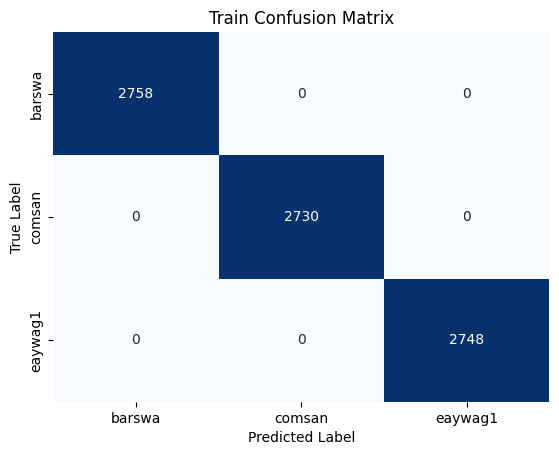

In [235]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

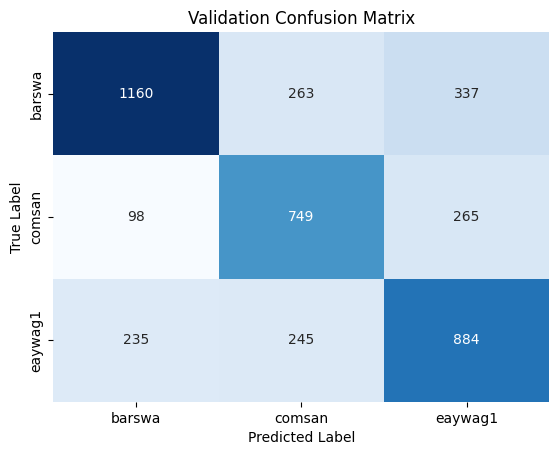

In [236]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only MFCC

### create features

In [237]:
training_features = train_features['mfcc']

training_features

array([[0.53904086, 0.6239877 , 0.6223028 , ..., 0.5601662 , 0.5168821 ,
        0.5083282 ],
       [0.1262853 , 0.26999906, 0.70732236, ..., 0.53563106, 0.5228654 ,
        0.524098  ],
       [0.470636  , 0.37839884, 0.42391407, ..., 0.5912193 , 0.6037487 ,
        0.59099245],
       ...,
       [0.55860466, 0.5602089 , 0.56102   , ..., 0.56524533, 0.51374036,
        0.4843961 ],
       [0.6382574 , 0.36704686, 0.5249311 , ..., 0.461285  , 0.3971088 ,
        0.49627385],
       [0.32321844, 0.3396854 , 0.29569247, ..., 0.53725874, 0.47914526,
        0.5120177 ]], dtype=float32)

In [238]:
training_features.shape

(8236, 20)

In [239]:
validation_features = val_features['mfcc']

validation_features

array([[0.7229811 , 0.5069471 , 0.50987154, ..., 0.4786958 , 0.47815743,
        0.41926628],
       [0.51392573, 0.64974934, 0.44175112, ..., 0.6297985 , 0.50234526,
        0.52082866],
       [0.47348937, 0.6383345 , 0.57761014, ..., 0.4297844 , 0.4881891 ,
        0.47738308],
       ...,
       [0.5031169 , 0.53660834, 0.45935526, ..., 0.56138974, 0.58648854,
        0.57225806],
       [0.79604983, 0.71014875, 0.47929445, ..., 0.56724536, 0.50365144,
        0.53245854],
       [0.51990575, 0.40287524, 0.7643232 , ..., 0.45773438, 0.4780996 ,
        0.62730587]], dtype=float32)

In [240]:
validation_features.shape

(4236, 20)

### fit the model with training data

In [241]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [242]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['mfcc'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['mfcc'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.6534466477809254


### evaluate the results

In [243]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [244]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.73      0.66      0.70      1760
      comsan       0.63      0.65      0.64      1112
     eaywag1       0.59      0.65      0.62      1364

    accuracy                           0.65      4236
   macro avg       0.65      0.65      0.65      4236
weighted avg       0.66      0.65      0.65      4236



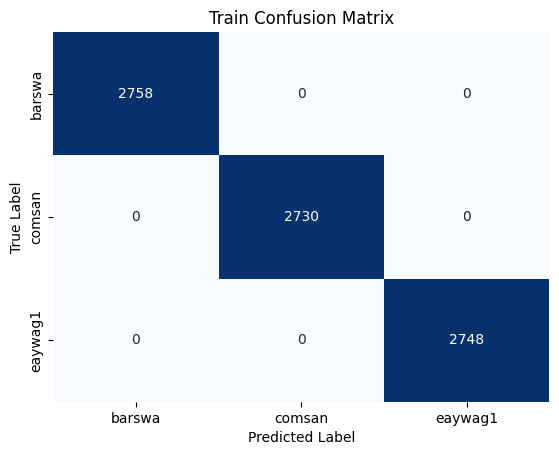

In [245]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

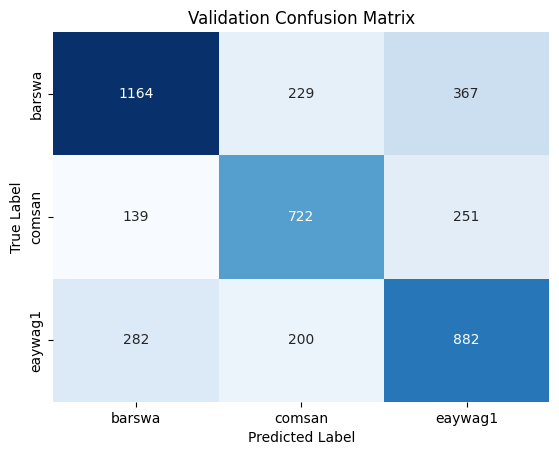

In [246]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only chroma

### create features

In [247]:
training_features = train_features['chroma']

training_features

array([[0.54487085, 0.6697674 , 0.6362764 , ..., 0.54313713, 0.50831896,
        0.47094157],
       [0.81646556, 0.8228168 , 0.706309  , ..., 0.39902177, 0.58745587,
        0.80136937],
       [0.51556563, 0.59242374, 0.60840005, ..., 0.28022945, 0.3133261 ,
        0.3399029 ],
       ...,
       [0.53488606, 0.67450833, 0.650471  , ..., 0.40428695, 0.38962966,
        0.44787553],
       [0.2791772 , 0.46630237, 0.60780567, ..., 0.18895227, 0.17213476,
        0.17138895],
       [0.36098987, 0.3807512 , 0.40050077, ..., 0.5193044 , 0.44192874,
        0.3706191 ]], dtype=float32)

In [248]:
training_features.shape

(8236, 12)

In [249]:
validation_features = val_features['chroma']

validation_features

array([[0.6732783 , 0.6649595 , 0.6364134 , ..., 0.7513435 , 0.6899959 ,
        0.6273005 ],
       [0.43542752, 0.4873883 , 0.43167138, ..., 0.536925  , 0.4062173 ,
        0.40946466],
       [0.54524153, 0.57394135, 0.6636713 , ..., 0.5447204 , 0.61368793,
        0.61719793],
       ...,
       [0.509695  , 0.5309402 , 0.59789443, ..., 0.7585997 , 0.69553417,
        0.58361703],
       [0.5891942 , 0.51433945, 0.47078356, ..., 0.68622583, 0.6716847 ,
        0.6862978 ],
       [0.03016676, 0.07413955, 0.21117559, ..., 0.02360593, 0.05792596,
        0.08580625]], dtype=float32)

In [250]:
validation_features.shape

(4236, 12)

### fit the model with training data

In [251]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [252]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['chroma'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['chroma'] = rf.score(validation_features, val_y)

Training accuracy: 0.9997571636716853
Validation accuracy: 0.5002360717658169


### evaluate the results

In [253]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [254]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.54      0.46      0.50      1760
      comsan       0.51      0.58      0.54      1112
     eaywag1       0.46      0.49      0.47      1364

    accuracy                           0.50      4236
   macro avg       0.50      0.51      0.50      4236
weighted avg       0.50      0.50      0.50      4236



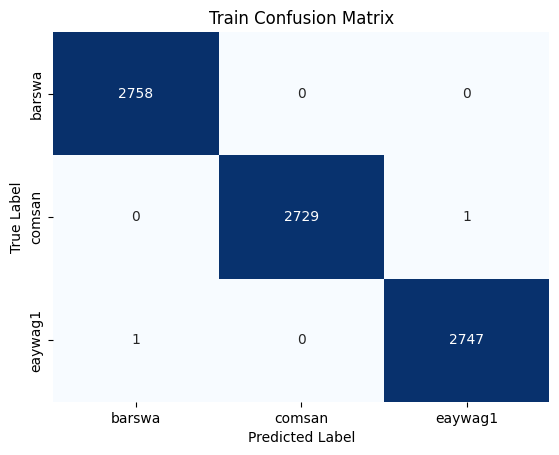

In [255]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

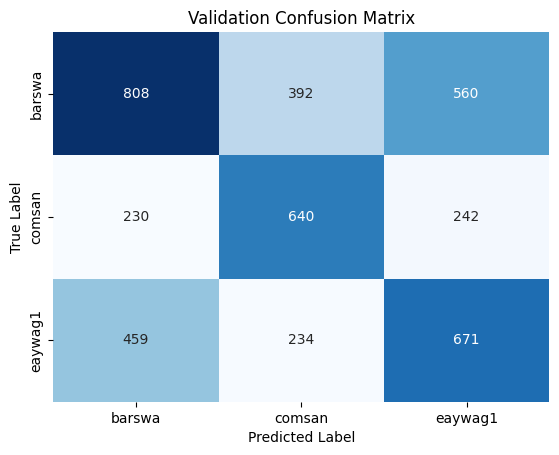

In [256]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only RMS & Spectral_Centroid

### create features

In [257]:
training_features = np.concatenate((train_features['rms'], train_features['spectral_centroid']), axis=1)

training_features

array([[1.5628168e-02, 3.7873065e-01],
       [6.4428302e-04, 7.1694744e-01],
       [1.6827893e-02, 5.7013386e-01],
       ...,
       [1.1244770e-02, 4.0194970e-01],
       [1.2223538e-01, 6.3965297e-01],
       [8.0159837e-03, 5.0712800e-01]], dtype=float32)

In [258]:
training_features.shape

(8236, 2)

In [259]:
validation_features = np.concatenate((val_features['rms'], val_features['spectral_centroid']), axis=1)

validation_features

array([[0.02654731, 0.48589835],
       [0.0062445 , 0.29833874],
       [0.00256066, 0.36876592],
       ...,
       [0.00309504, 0.45962748],
       [0.0657605 , 0.2375576 ],
       [0.1382814 , 0.67972773]], dtype=float32)

In [260]:
validation_features.shape

(4236, 2)

### fit the model with training data

In [261]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [262]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['rms_spectral_centroid'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['rms_spectral_centroid'] = rf.score(validation_features, val_y)

Training accuracy: 0.9992714910150559
Validation accuracy: 0.4256373937677054


### evaluate the results

In [263]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [264]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.50      0.41      0.45      1760
      comsan       0.39      0.46      0.42      1112
     eaywag1       0.38      0.42      0.40      1364

    accuracy                           0.43      4236
   macro avg       0.43      0.43      0.42      4236
weighted avg       0.43      0.43      0.43      4236



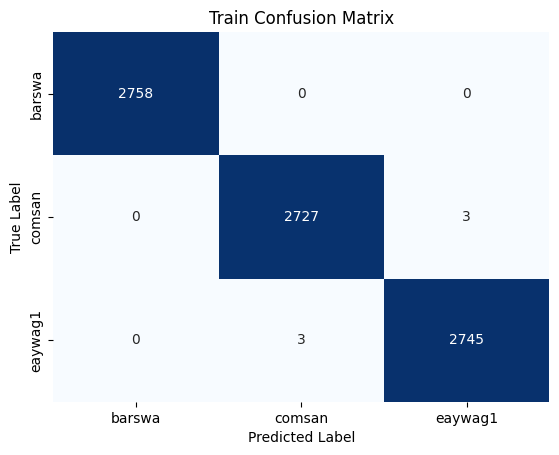

In [265]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

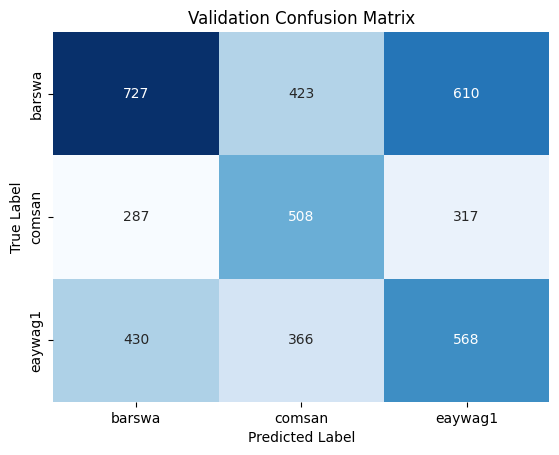

In [266]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only melspectrogram

### create features

In [267]:
training_features = train_features['melspectrogram']

training_features

array([[0.65363264, 0.55276763, 0.521255  , ..., 0.4352727 , 0.40918028,
        0.39084634],
       [0.09282181, 0.0734781 , 0.03894596, ..., 0.33126852, 0.3265114 ,
        0.29915738],
       [0.2538517 , 0.33768472, 0.338466  , ..., 0.49013135, 0.46203706,
        0.4353609 ],
       ...,
       [0.63044596, 0.49771532, 0.46224692, ..., 0.4283666 , 0.4399649 ,
        0.44011343],
       [0.47139457, 0.42599458, 0.4788285 , ..., 0.7253964 , 0.6576638 ,
        0.5816639 ],
       [0.13799357, 0.06639971, 0.03519248, ..., 0.39391512, 0.2950327 ,
        0.25640178]], dtype=float32)

In [268]:
training_features.shape

(8236, 20)

In [269]:
validation_features = val_features['melspectrogram']

validation_features

array([[0.6061899 , 0.66626644, 0.6829294 , ..., 0.5888606 , 0.58450496,
        0.5705415 ],
       [0.5366486 , 0.4829943 , 0.48725924, ..., 0.3386111 , 0.30269468,
        0.27938265],
       [0.5443551 , 0.5202885 , 0.49293303, ..., 0.338934  , 0.32230356,
        0.29273444],
       ...,
       [0.4124891 , 0.43576792, 0.4574656 , ..., 0.38564605, 0.38928664,
        0.3876472 ],
       [0.7080118 , 0.8139034 , 0.8622843 , ..., 0.54666704, 0.53936094,
        0.5042509 ],
       [0.49358806, 0.5025375 , 0.47798836, ..., 0.7865666 , 0.6430179 ,
        0.46950492]], dtype=float32)

In [270]:
validation_features.shape

(4236, 20)

### fit the model with training data

In [271]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [272]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['melspectrogram'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['melspectrogram'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.5554768649669499


### evaluate the results

In [273]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [274]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.67      0.58      0.62      1760
      comsan       0.53      0.56      0.54      1112
     eaywag1       0.47      0.53      0.49      1364

    accuracy                           0.56      4236
   macro avg       0.55      0.55      0.55      4236
weighted avg       0.57      0.56      0.56      4236



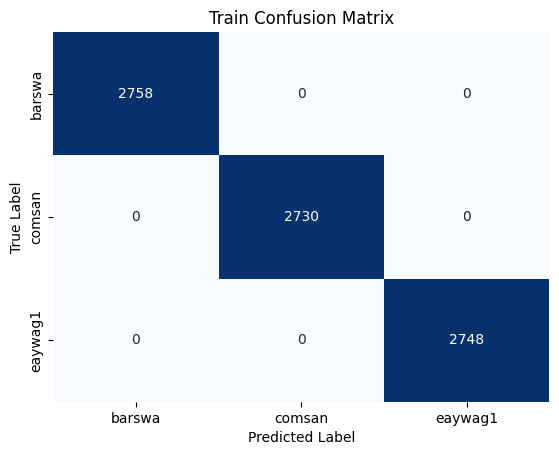

In [275]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

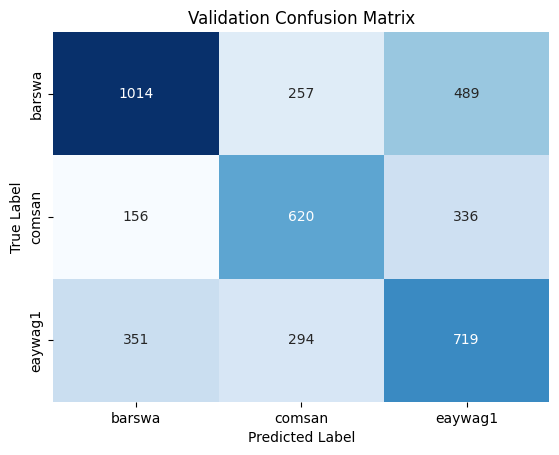

In [276]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & continents

### create features

In [277]:
training_features = np.concatenate((train_features['mfcc'], train_continents), axis=1)

training_features

array([[0.53904086, 0.62398767, 0.62230277, ..., 0.        , 1.        ,
        0.        ],
       [0.1262853 , 0.26999906, 0.70732236, ..., 0.        , 1.        ,
        0.        ],
       [0.47063601, 0.37839884, 0.42391407, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.55860466, 0.56020892, 0.56102002, ..., 0.        , 1.        ,
        0.        ],
       [0.63825738, 0.36704686, 0.52493107, ..., 0.        , 0.        ,
        0.        ],
       [0.32321844, 0.33968541, 0.29569247, ..., 0.        , 1.        ,
        0.        ]])

In [278]:
training_features.shape

(8236, 25)

In [279]:
validation_features = np.concatenate((val_features['mfcc'], val_continents), axis=1)

validation_features

array([[0.7229811 , 0.5069471 , 0.50987154, ..., 0.        , 1.        ,
        0.        ],
       [0.51392573, 0.64974934, 0.44175112, ..., 0.        , 1.        ,
        0.        ],
       [0.47348937, 0.63833451, 0.57761014, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.50311691, 0.53660834, 0.45935526, ..., 0.        , 1.        ,
        0.        ],
       [0.79604983, 0.71014875, 0.47929445, ..., 0.        , 1.        ,
        0.        ],
       [0.51990575, 0.40287524, 0.76432317, ..., 0.        , 1.        ,
        0.        ]])

In [280]:
validation_features.shape

(4236, 25)

### fit the model with training data

In [281]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [282]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['mfcc_continents'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['mfcc_continents'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.6905099150141643


### evaluate the results

In [283]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [284]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.78      0.66      0.72      1760
      comsan       0.65      0.68      0.67      1112
     eaywag1       0.63      0.73      0.68      1364

    accuracy                           0.69      4236
   macro avg       0.69      0.69      0.69      4236
weighted avg       0.70      0.69      0.69      4236



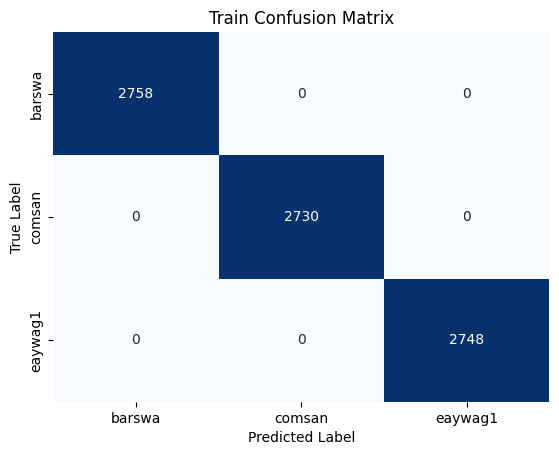

In [285]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

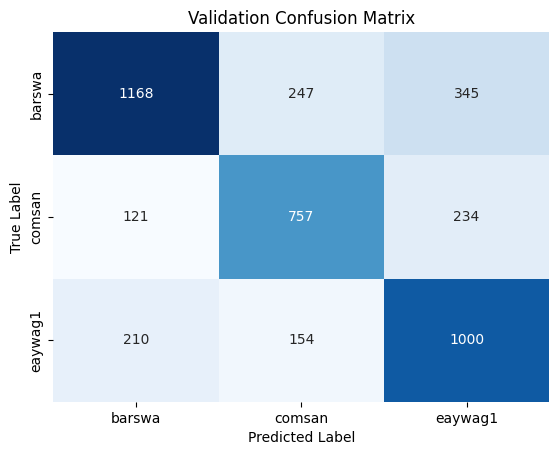

In [286]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & chroma

### create features

In [287]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'],), axis=1)

training_features

array([[0.53904086, 0.6239877 , 0.6223028 , ..., 0.54313713, 0.50831896,
        0.47094157],
       [0.1262853 , 0.26999906, 0.70732236, ..., 0.39902177, 0.58745587,
        0.80136937],
       [0.470636  , 0.37839884, 0.42391407, ..., 0.28022945, 0.3133261 ,
        0.3399029 ],
       ...,
       [0.55860466, 0.5602089 , 0.56102   , ..., 0.40428695, 0.38962966,
        0.44787553],
       [0.6382574 , 0.36704686, 0.5249311 , ..., 0.18895227, 0.17213476,
        0.17138895],
       [0.32321844, 0.3396854 , 0.29569247, ..., 0.5193044 , 0.44192874,
        0.3706191 ]], dtype=float32)

In [288]:
training_features.shape

(8236, 32)

In [289]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma']), axis=1)

validation_features

array([[0.7229811 , 0.5069471 , 0.50987154, ..., 0.7513435 , 0.6899959 ,
        0.6273005 ],
       [0.51392573, 0.64974934, 0.44175112, ..., 0.536925  , 0.4062173 ,
        0.40946466],
       [0.47348937, 0.6383345 , 0.57761014, ..., 0.5447204 , 0.61368793,
        0.61719793],
       ...,
       [0.5031169 , 0.53660834, 0.45935526, ..., 0.7585997 , 0.69553417,
        0.58361703],
       [0.79604983, 0.71014875, 0.47929445, ..., 0.68622583, 0.6716847 ,
        0.6862978 ],
       [0.51990575, 0.40287524, 0.7643232 , ..., 0.02360593, 0.05792596,
        0.08580625]], dtype=float32)

In [290]:
validation_features.shape

(4236, 32)

### fit the model with training data

In [291]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [292]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['mfcc_chroma'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['mfcc_chroma'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.6584041548630784


### evaluate the results

In [293]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [294]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.74      0.64      0.68      1760
      comsan       0.62      0.68      0.65      1112
     eaywag1       0.61      0.67      0.64      1364

    accuracy                           0.66      4236
   macro avg       0.66      0.66      0.66      4236
weighted avg       0.67      0.66      0.66      4236



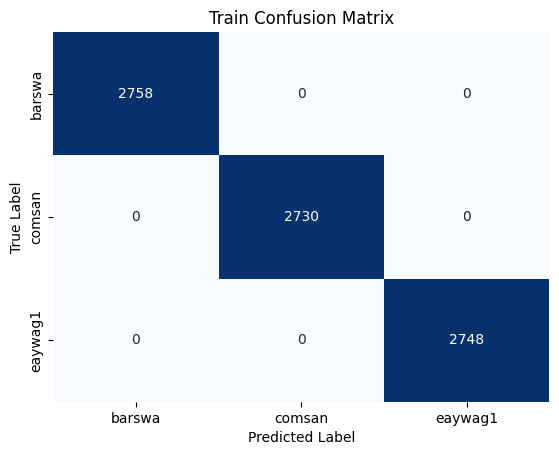

In [295]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

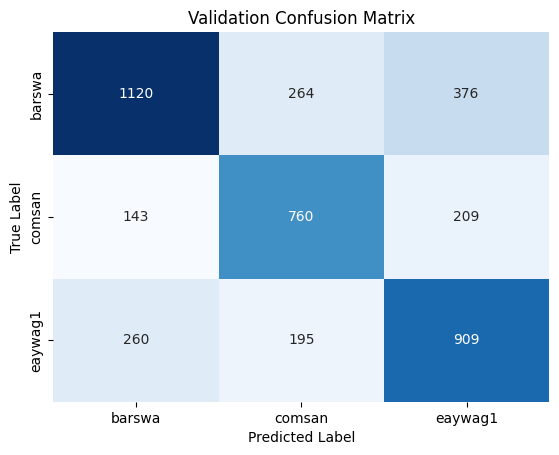

In [296]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & chroma & continents

### create features

In [297]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_continents), axis=1)

training_features

array([[0.53904086, 0.62398767, 0.62230277, ..., 0.        , 1.        ,
        0.        ],
       [0.1262853 , 0.26999906, 0.70732236, ..., 0.        , 1.        ,
        0.        ],
       [0.47063601, 0.37839884, 0.42391407, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.55860466, 0.56020892, 0.56102002, ..., 0.        , 1.        ,
        0.        ],
       [0.63825738, 0.36704686, 0.52493107, ..., 0.        , 0.        ,
        0.        ],
       [0.32321844, 0.33968541, 0.29569247, ..., 0.        , 1.        ,
        0.        ]])

In [298]:
training_features.shape

(8236, 37)

In [299]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_continents), axis=1)

validation_features

array([[0.7229811 , 0.5069471 , 0.50987154, ..., 0.        , 1.        ,
        0.        ],
       [0.51392573, 0.64974934, 0.44175112, ..., 0.        , 1.        ,
        0.        ],
       [0.47348937, 0.63833451, 0.57761014, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.50311691, 0.53660834, 0.45935526, ..., 0.        , 1.        ,
        0.        ],
       [0.79604983, 0.71014875, 0.47929445, ..., 0.        , 1.        ,
        0.        ],
       [0.51990575, 0.40287524, 0.76432317, ..., 0.        , 1.        ,
        0.        ]])

In [300]:
validation_features.shape

(4236, 37)

### fit the model with training data

In [301]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [302]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['mfcc_chroma_continents'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['mfcc_chroma_continents'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.704438149197356


### evaluate the results

In [303]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [304]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.79      0.67      0.73      1760
      comsan       0.68      0.71      0.69      1112
     eaywag1       0.64      0.75      0.69      1364

    accuracy                           0.70      4236
   macro avg       0.70      0.71      0.70      4236
weighted avg       0.71      0.70      0.71      4236



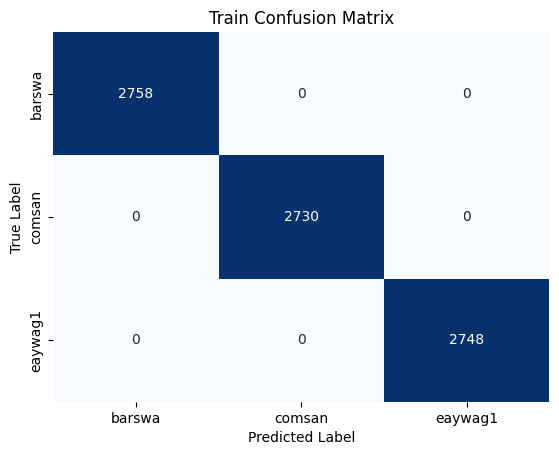

In [305]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

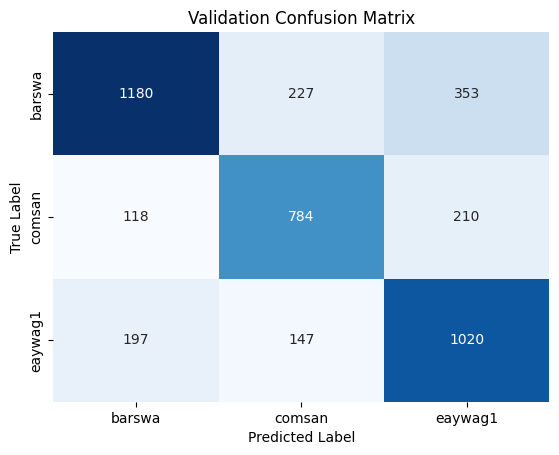

In [306]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & rms & spectral_centroid

### create features

In [307]:
training_features = np.concatenate((train_features['mfcc'], train_features['rms'], train_features['spectral_centroid']), axis=1)

training_features

array([[5.3904086e-01, 6.2398767e-01, 6.2230277e-01, ..., 5.0832820e-01,
        1.5628168e-02, 3.7873065e-01],
       [1.2628530e-01, 2.6999906e-01, 7.0732236e-01, ..., 5.2409798e-01,
        6.4428302e-04, 7.1694744e-01],
       [4.7063601e-01, 3.7839884e-01, 4.2391407e-01, ..., 5.9099245e-01,
        1.6827893e-02, 5.7013386e-01],
       ...,
       [5.5860466e-01, 5.6020892e-01, 5.6102002e-01, ..., 4.8439610e-01,
        1.1244770e-02, 4.0194970e-01],
       [6.3825738e-01, 3.6704686e-01, 5.2493107e-01, ..., 4.9627385e-01,
        1.2223538e-01, 6.3965297e-01],
       [3.2321844e-01, 3.3968541e-01, 2.9569247e-01, ..., 5.1201773e-01,
        8.0159837e-03, 5.0712800e-01]], dtype=float32)

In [308]:
training_features.shape

(8236, 22)

In [309]:
validation_features = np.concatenate((val_features['mfcc'], val_features['rms'], val_features['spectral_centroid']), axis=1)

validation_features

array([[0.7229811 , 0.5069471 , 0.50987154, ..., 0.41926628, 0.02654731,
        0.48589835],
       [0.51392573, 0.64974934, 0.44175112, ..., 0.52082866, 0.0062445 ,
        0.29833874],
       [0.47348937, 0.6383345 , 0.57761014, ..., 0.47738308, 0.00256066,
        0.36876592],
       ...,
       [0.5031169 , 0.53660834, 0.45935526, ..., 0.57225806, 0.00309504,
        0.45962748],
       [0.79604983, 0.71014875, 0.47929445, ..., 0.53245854, 0.0657605 ,
        0.2375576 ],
       [0.51990575, 0.40287524, 0.7643232 , ..., 0.62730587, 0.1382814 ,
        0.67972773]], dtype=float32)

In [310]:
validation_features.shape

(4236, 22)

### fit the model with training data

In [311]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [312]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['mfcc_rms_spectral_centroid'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['mfcc_rms_spectral_centroid'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.6487252124645893


### evaluate the results

In [313]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [314]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.72      0.64      0.68      1760
      comsan       0.61      0.68      0.64      1112
     eaywag1       0.61      0.64      0.62      1364

    accuracy                           0.65      4236
   macro avg       0.64      0.65      0.65      4236
weighted avg       0.65      0.65      0.65      4236



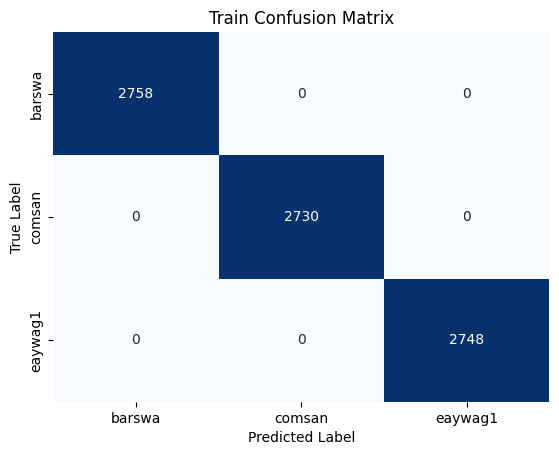

In [315]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

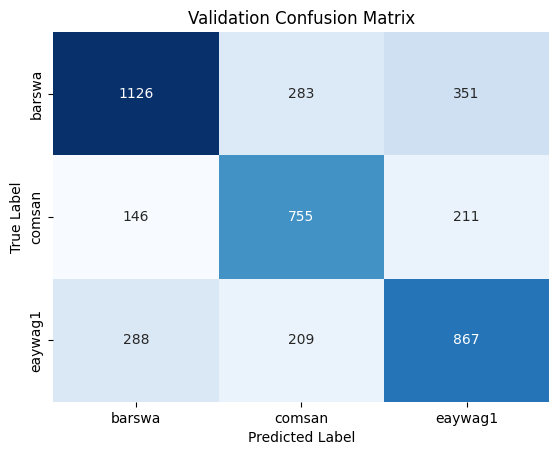

In [316]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & rms & continents

### create features

In [317]:
training_features = np.concatenate((train_features['mfcc'], train_features['rms'], train_continents), axis=1)

training_features

array([[0.53904086, 0.62398767, 0.62230277, ..., 0.        , 1.        ,
        0.        ],
       [0.1262853 , 0.26999906, 0.70732236, ..., 0.        , 1.        ,
        0.        ],
       [0.47063601, 0.37839884, 0.42391407, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.55860466, 0.56020892, 0.56102002, ..., 0.        , 1.        ,
        0.        ],
       [0.63825738, 0.36704686, 0.52493107, ..., 0.        , 0.        ,
        0.        ],
       [0.32321844, 0.33968541, 0.29569247, ..., 0.        , 1.        ,
        0.        ]])

In [318]:
training_features.shape

(8236, 26)

In [319]:
validation_features = np.concatenate((val_features['mfcc'], val_features['rms'], val_continents), axis=1)

validation_features

array([[0.7229811 , 0.5069471 , 0.50987154, ..., 0.        , 1.        ,
        0.        ],
       [0.51392573, 0.64974934, 0.44175112, ..., 0.        , 1.        ,
        0.        ],
       [0.47348937, 0.63833451, 0.57761014, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.50311691, 0.53660834, 0.45935526, ..., 0.        , 1.        ,
        0.        ],
       [0.79604983, 0.71014875, 0.47929445, ..., 0.        , 1.        ,
        0.        ],
       [0.51990575, 0.40287524, 0.76432317, ..., 0.        , 1.        ,
        0.        ]])

In [320]:
validation_features.shape

(4236, 26)

### fit the model with training data

In [321]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [322]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['mfcc_rms_continents'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['mfcc_rms_continents'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.6843720491029273


### evaluate the results

In [323]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [324]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.78      0.66      0.72      1760
      comsan       0.64      0.68      0.66      1112
     eaywag1       0.63      0.71      0.67      1364

    accuracy                           0.68      4236
   macro avg       0.68      0.69      0.68      4236
weighted avg       0.69      0.68      0.69      4236



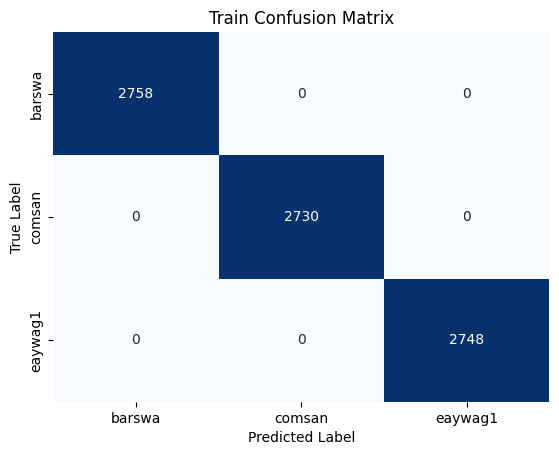

In [325]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

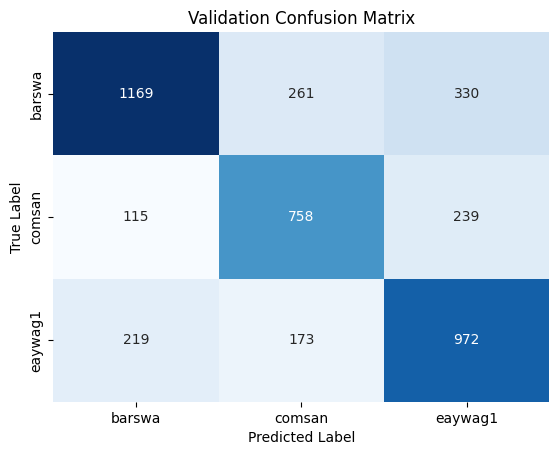

In [326]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & spectral_centroid & continents

### create features

In [327]:
training_features = np.concatenate((train_features['mfcc'], train_features['spectral_centroid'], train_continents), axis=1)

training_features

array([[0.53904086, 0.62398767, 0.62230277, ..., 0.        , 1.        ,
        0.        ],
       [0.1262853 , 0.26999906, 0.70732236, ..., 0.        , 1.        ,
        0.        ],
       [0.47063601, 0.37839884, 0.42391407, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.55860466, 0.56020892, 0.56102002, ..., 0.        , 1.        ,
        0.        ],
       [0.63825738, 0.36704686, 0.52493107, ..., 0.        , 0.        ,
        0.        ],
       [0.32321844, 0.33968541, 0.29569247, ..., 0.        , 1.        ,
        0.        ]])

In [328]:
training_features.shape

(8236, 26)

In [329]:
validation_features = np.concatenate((val_features['mfcc'], val_features['spectral_centroid'], val_continents), axis=1)

validation_features

array([[0.7229811 , 0.5069471 , 0.50987154, ..., 0.        , 1.        ,
        0.        ],
       [0.51392573, 0.64974934, 0.44175112, ..., 0.        , 1.        ,
        0.        ],
       [0.47348937, 0.63833451, 0.57761014, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.50311691, 0.53660834, 0.45935526, ..., 0.        , 1.        ,
        0.        ],
       [0.79604983, 0.71014875, 0.47929445, ..., 0.        , 1.        ,
        0.        ],
       [0.51990575, 0.40287524, 0.76432317, ..., 0.        , 1.        ,
        0.        ]])

In [330]:
validation_features.shape

(4236, 26)

### fit the model with training data

In [331]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [332]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['mfcc_spectral_centroid_continents'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['mfcc_spectral_centroid_continents'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.6827195467422096


### evaluate the results

In [333]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [334]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.78      0.65      0.71      1760
      comsan       0.64      0.70      0.67      1112
     eaywag1       0.62      0.71      0.66      1364

    accuracy                           0.68      4236
   macro avg       0.68      0.69      0.68      4236
weighted avg       0.69      0.68      0.68      4236



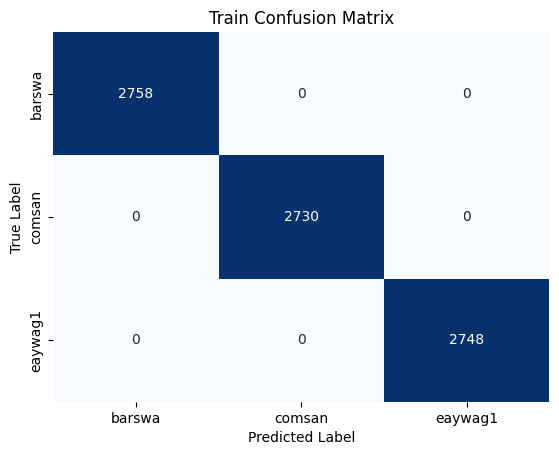

In [335]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

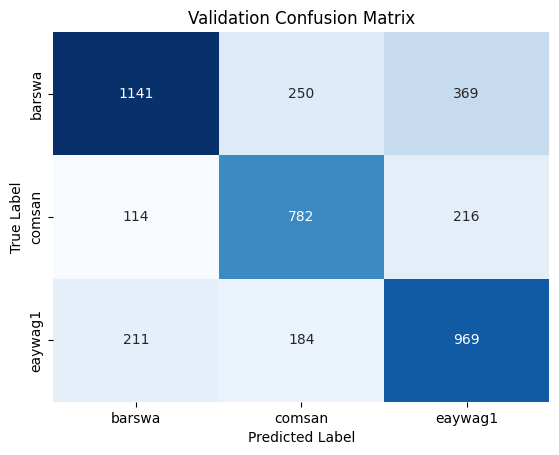

In [336]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & chroma

### create features

In [337]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma']), axis=1)

training_features

array([[0.65363264, 0.55276763, 0.521255  , ..., 0.54313713, 0.50831896,
        0.47094157],
       [0.09282181, 0.0734781 , 0.03894596, ..., 0.39902177, 0.58745587,
        0.80136937],
       [0.2538517 , 0.33768472, 0.338466  , ..., 0.28022945, 0.3133261 ,
        0.3399029 ],
       ...,
       [0.63044596, 0.49771532, 0.46224692, ..., 0.40428695, 0.38962966,
        0.44787553],
       [0.47139457, 0.42599458, 0.4788285 , ..., 0.18895227, 0.17213476,
        0.17138895],
       [0.13799357, 0.06639971, 0.03519248, ..., 0.5193044 , 0.44192874,
        0.3706191 ]], dtype=float32)

In [338]:
training_features.shape

(8236, 32)

In [339]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma']), axis=1)

validation_features

array([[0.6061899 , 0.66626644, 0.6829294 , ..., 0.7513435 , 0.6899959 ,
        0.6273005 ],
       [0.5366486 , 0.4829943 , 0.48725924, ..., 0.536925  , 0.4062173 ,
        0.40946466],
       [0.5443551 , 0.5202885 , 0.49293303, ..., 0.5447204 , 0.61368793,
        0.61719793],
       ...,
       [0.4124891 , 0.43576792, 0.4574656 , ..., 0.7585997 , 0.69553417,
        0.58361703],
       [0.7080118 , 0.8139034 , 0.8622843 , ..., 0.68622583, 0.6716847 ,
        0.6862978 ],
       [0.49358806, 0.5025375 , 0.47798836, ..., 0.02360593, 0.05792596,
        0.08580625]], dtype=float32)

In [340]:
validation_features.shape

(4236, 32)

### fit the model with training data

In [341]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [342]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['melspectrogram_chroma'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['melspectrogram_chroma'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.5984419263456091


### evaluate the results

In [343]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [344]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.72      0.61      0.66      1760
      comsan       0.55      0.63      0.59      1112
     eaywag1       0.52      0.57      0.54      1364

    accuracy                           0.60      4236
   macro avg       0.60      0.60      0.60      4236
weighted avg       0.61      0.60      0.60      4236



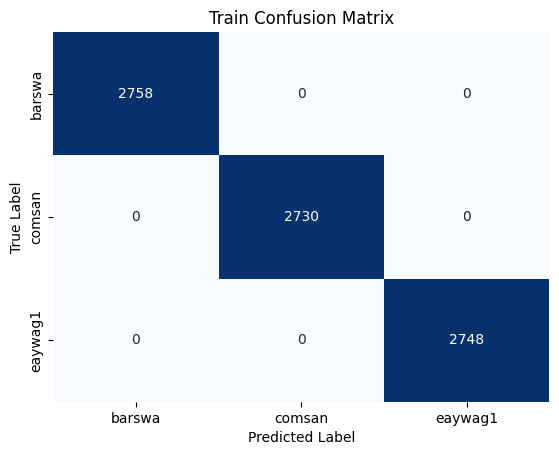

In [345]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

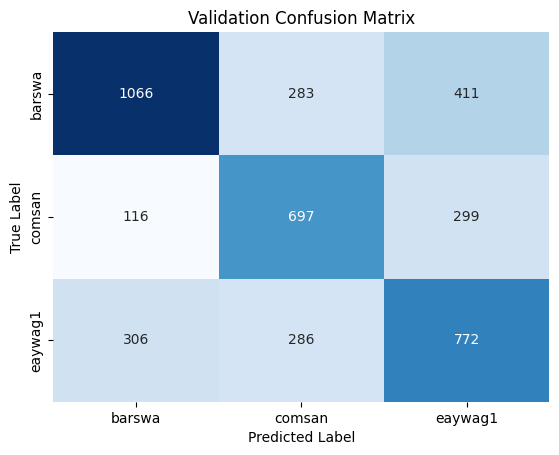

In [346]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & chroma & continents

### create features

In [347]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_continents), axis=1)

training_features

array([[0.65363264, 0.55276763, 0.52125502, ..., 0.        , 1.        ,
        0.        ],
       [0.09282181, 0.0734781 , 0.03894596, ..., 0.        , 1.        ,
        0.        ],
       [0.25385171, 0.33768472, 0.33846599, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.63044596, 0.49771532, 0.46224692, ..., 0.        , 1.        ,
        0.        ],
       [0.47139457, 0.42599458, 0.47882849, ..., 0.        , 0.        ,
        0.        ],
       [0.13799357, 0.06639971, 0.03519248, ..., 0.        , 1.        ,
        0.        ]])

In [348]:
training_features.shape

(8236, 37)

In [349]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_continents), axis=1)

validation_features

array([[0.60618991, 0.66626644, 0.6829294 , ..., 0.        , 1.        ,
        0.        ],
       [0.53664857, 0.48299429, 0.48725924, ..., 0.        , 1.        ,
        0.        ],
       [0.54435509, 0.52028853, 0.49293303, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.41248909, 0.43576792, 0.45746559, ..., 0.        , 1.        ,
        0.        ],
       [0.70801181, 0.81390339, 0.8622843 , ..., 0.        , 1.        ,
        0.        ],
       [0.49358806, 0.50253749, 0.47798836, ..., 0.        , 1.        ,
        0.        ]])

In [350]:
validation_features.shape

(4236, 37)

### fit the model with training data

In [351]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [352]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['melspectrogram_chroma_continents'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['melspectrogram_chroma_continents'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.6364494806421152


### evaluate the results

In [353]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [354]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.78      0.64      0.70      1760
      comsan       0.59      0.63      0.61      1112
     eaywag1       0.54      0.64      0.59      1364

    accuracy                           0.64      4236
   macro avg       0.64      0.64      0.63      4236
weighted avg       0.65      0.64      0.64      4236



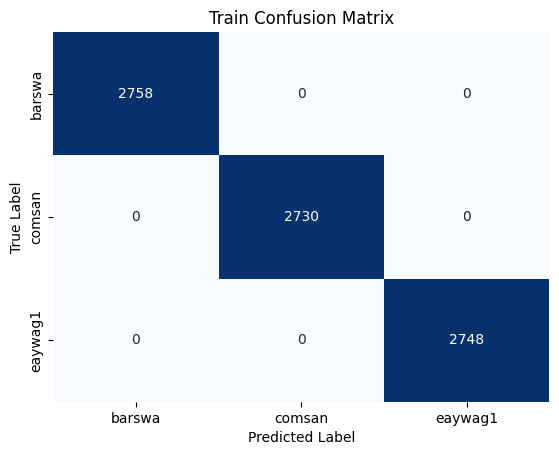

In [355]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

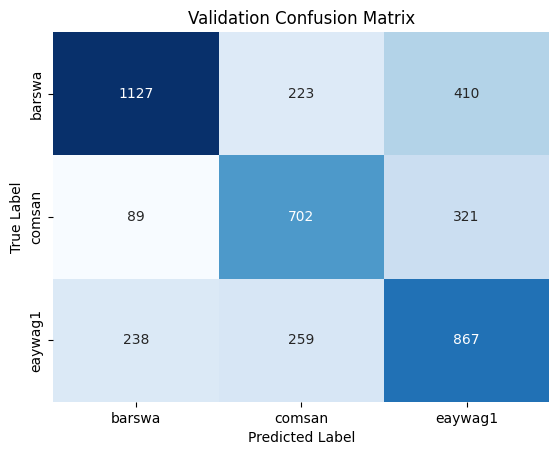

In [356]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & rms & spectral_centroid

### create features

In [357]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['rms'], train_features['spectral_centroid']), axis=1)

training_features

array([[6.5363264e-01, 5.5276763e-01, 5.2125502e-01, ..., 3.9084634e-01,
        1.5628168e-02, 3.7873065e-01],
       [9.2821807e-02, 7.3478095e-02, 3.8945962e-02, ..., 2.9915738e-01,
        6.4428302e-04, 7.1694744e-01],
       [2.5385171e-01, 3.3768472e-01, 3.3846599e-01, ..., 4.3536091e-01,
        1.6827893e-02, 5.7013386e-01],
       ...,
       [6.3044596e-01, 4.9771532e-01, 4.6224692e-01, ..., 4.4011343e-01,
        1.1244770e-02, 4.0194970e-01],
       [4.7139457e-01, 4.2599458e-01, 4.7882849e-01, ..., 5.8166391e-01,
        1.2223538e-01, 6.3965297e-01],
       [1.3799357e-01, 6.6399708e-02, 3.5192478e-02, ..., 2.5640178e-01,
        8.0159837e-03, 5.0712800e-01]], dtype=float32)

In [358]:
training_features.shape

(8236, 22)

In [359]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['rms'], val_features['spectral_centroid']), axis=1)

validation_features

array([[0.6061899 , 0.66626644, 0.6829294 , ..., 0.5705415 , 0.02654731,
        0.48589835],
       [0.5366486 , 0.4829943 , 0.48725924, ..., 0.27938265, 0.0062445 ,
        0.29833874],
       [0.5443551 , 0.5202885 , 0.49293303, ..., 0.29273444, 0.00256066,
        0.36876592],
       ...,
       [0.4124891 , 0.43576792, 0.4574656 , ..., 0.3876472 , 0.00309504,
        0.45962748],
       [0.7080118 , 0.8139034 , 0.8622843 , ..., 0.5042509 , 0.0657605 ,
        0.2375576 ],
       [0.49358806, 0.5025375 , 0.47798836, ..., 0.46950492, 0.1382814 ,
        0.67972773]], dtype=float32)

In [360]:
validation_features.shape

(4236, 22)

### fit the model with training data

In [361]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [362]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['melspectrogram_rms_spectral_centroid'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['melspectrogram_rms_spectral_centroid'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.5656279508970727


### evaluate the results

In [363]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [364]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.67      0.59      0.63      1760
      comsan       0.53      0.61      0.57      1112
     eaywag1       0.48      0.50      0.49      1364

    accuracy                           0.57      4236
   macro avg       0.56      0.57      0.56      4236
weighted avg       0.57      0.57      0.57      4236



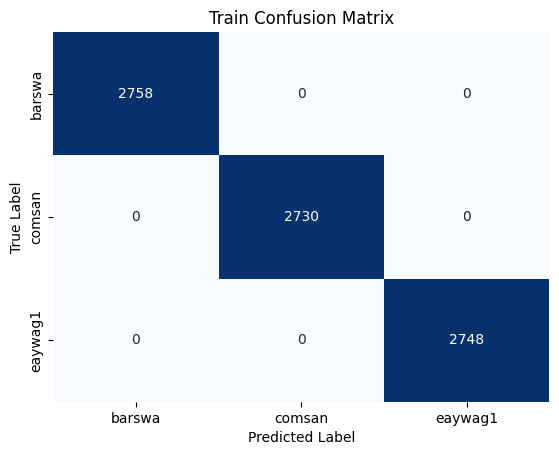

In [365]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

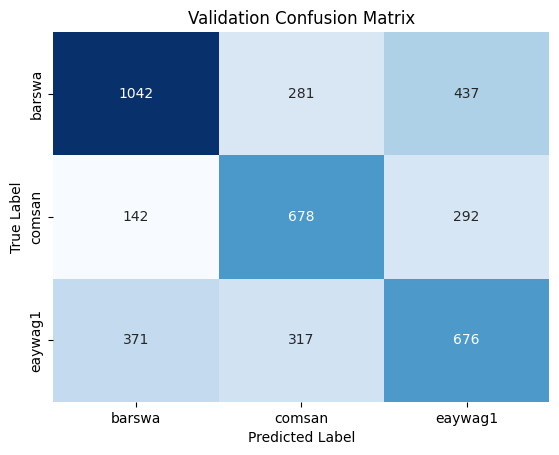

In [366]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & rms & continents

### create features

In [367]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['rms'], train_continents), axis=1)

training_features

array([[0.65363264, 0.55276763, 0.52125502, ..., 0.        , 1.        ,
        0.        ],
       [0.09282181, 0.0734781 , 0.03894596, ..., 0.        , 1.        ,
        0.        ],
       [0.25385171, 0.33768472, 0.33846599, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.63044596, 0.49771532, 0.46224692, ..., 0.        , 1.        ,
        0.        ],
       [0.47139457, 0.42599458, 0.47882849, ..., 0.        , 0.        ,
        0.        ],
       [0.13799357, 0.06639971, 0.03519248, ..., 0.        , 1.        ,
        0.        ]])

In [368]:
training_features.shape

(8236, 26)

In [369]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['rms'], val_continents), axis=1)

validation_features

array([[0.60618991, 0.66626644, 0.6829294 , ..., 0.        , 1.        ,
        0.        ],
       [0.53664857, 0.48299429, 0.48725924, ..., 0.        , 1.        ,
        0.        ],
       [0.54435509, 0.52028853, 0.49293303, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.41248909, 0.43576792, 0.45746559, ..., 0.        , 1.        ,
        0.        ],
       [0.70801181, 0.81390339, 0.8622843 , ..., 0.        , 1.        ,
        0.        ],
       [0.49358806, 0.50253749, 0.47798836, ..., 0.        , 1.        ,
        0.        ]])

In [370]:
validation_features.shape

(4236, 26)

### fit the model with training data

In [371]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [372]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['melspectrogram_rms_continents'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['melspectrogram_rms_continents'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.6166194523135033


### evaluate the results

In [373]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [374]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.75      0.65      0.69      1760
      comsan       0.57      0.60      0.58      1112
     eaywag1       0.52      0.59      0.56      1364

    accuracy                           0.62      4236
   macro avg       0.61      0.61      0.61      4236
weighted avg       0.63      0.62      0.62      4236



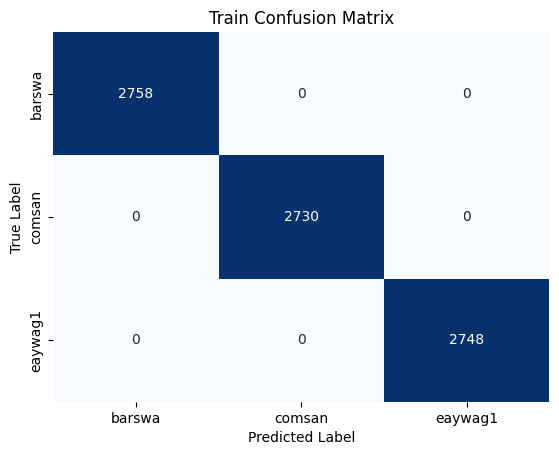

In [375]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

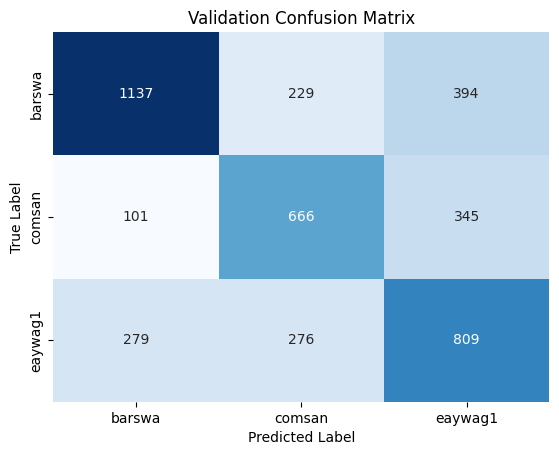

In [376]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & spectral_centroid & continents

### create features

In [377]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['spectral_centroid'], train_continents), axis=1)

training_features

array([[0.65363264, 0.55276763, 0.52125502, ..., 0.        , 1.        ,
        0.        ],
       [0.09282181, 0.0734781 , 0.03894596, ..., 0.        , 1.        ,
        0.        ],
       [0.25385171, 0.33768472, 0.33846599, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.63044596, 0.49771532, 0.46224692, ..., 0.        , 1.        ,
        0.        ],
       [0.47139457, 0.42599458, 0.47882849, ..., 0.        , 0.        ,
        0.        ],
       [0.13799357, 0.06639971, 0.03519248, ..., 0.        , 1.        ,
        0.        ]])

In [378]:
training_features.shape

(8236, 26)

In [379]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['spectral_centroid'], val_continents), axis=1)

validation_features

array([[0.60618991, 0.66626644, 0.6829294 , ..., 0.        , 1.        ,
        0.        ],
       [0.53664857, 0.48299429, 0.48725924, ..., 0.        , 1.        ,
        0.        ],
       [0.54435509, 0.52028853, 0.49293303, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.41248909, 0.43576792, 0.45746559, ..., 0.        , 1.        ,
        0.        ],
       [0.70801181, 0.81390339, 0.8622843 , ..., 0.        , 1.        ,
        0.        ],
       [0.49358806, 0.50253749, 0.47798836, ..., 0.        , 1.        ,
        0.        ]])

In [380]:
validation_features.shape

(4236, 26)

### fit the model with training data

In [381]:
rf = RandomForestClassifier(n_estimators=50, criterion='entropy')
rf.fit(training_features, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [382]:
print('Training accuracy:', rf.score(training_features, train_y))
train_results['melspectrogram_spectral_centroid_continents'] = rf.score(training_features, train_y)

print('Validation accuracy:', rf.score(validation_features, val_y))
val_results['melspectrogram_spectral_centroid_continents'] = rf.score(validation_features, val_y)

Training accuracy: 1.0
Validation accuracy: 0.5996222851746931


### evaluate the results

In [383]:
train_yhat_result = rf.predict(training_features)

print('Training classification Report \n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      2758
      comsan       1.00      1.00      1.00      2730
     eaywag1       1.00      1.00      1.00      2748

    accuracy                           1.00      8236
   macro avg       1.00      1.00      1.00      8236
weighted avg       1.00      1.00      1.00      8236



In [384]:
val_yhat_result = rf.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.74      0.62      0.67      1760
      comsan       0.57      0.56      0.57      1112
     eaywag1       0.49      0.61      0.55      1364

    accuracy                           0.60      4236
   macro avg       0.60      0.60      0.60      4236
weighted avg       0.62      0.60      0.60      4236



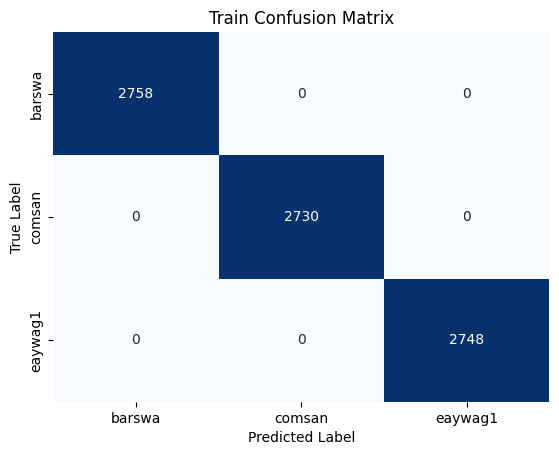

In [385]:
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

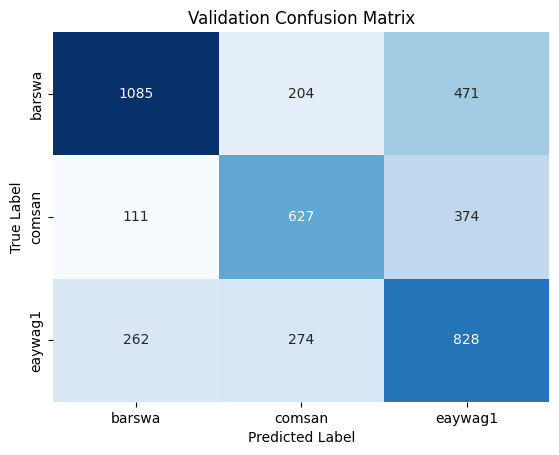

In [386]:
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

# Review results from all models

In [387]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Val_Accuracy')
result_df

,Features,Train_Accuracy,Val_Accuracy
3,rms_spectral_centroid,1.0,0.43
2,chroma,1.0,0.50
4,melspectrogram,1.0,0.56
13,melspectrogram_rms_spectral_centroid,1.0,0.57
11,melspectrogram_chroma,1.0,0.60
15,melspectrogram_spectral_centroid_continents,1.0,0.60
14,melspectrogram_rms_continents,1.0,0.62
12,melspectrogram_chroma_continents,1.0,0.64
1,mfcc,1.0,0.65
8,mfcc_rms_spectral_centroid,1.0,0.65
